# Eigennamen
## Details
> Door een eigennaam van een betrokken persoon te gebruiken  in  een  titel,  in  plaats  van  een generieke benoeming, voelen de lezers sneller een band tussen henzelfen  de  besproken  persoon,omdat  de  lezers het  gevoel  hebben  dat  ze  de  persoon  in  kwestie kennen, waardoor de lezers sneller zouden klikken.
## Example
> 'Temptation'-Yana krijgt vier maanden effectieve celstraf na handtasdiefstalVs. ‘Temptation  Island’-verleidstermoet   vier maanden naar gevangenis



## Data

In [1]:
from util import get_cls_train_test

train_x, train_y, test_x, test_y = get_cls_train_test("Eigennamen")
train_y.value_counts()

0    621
1     60
Name: Eigennamen, dtype: int64

## Approach 1: Tf-idf
With tf-idf or just a count vectorizer, we might already achieve quite a good result, since it just needs to learn some adjectives.

f-score: 0.29411764705882354
Confusion matrix: (TP: 199, FP: 4, FN: 20, TN: 5)
Accuracy=89.47% (204/228)


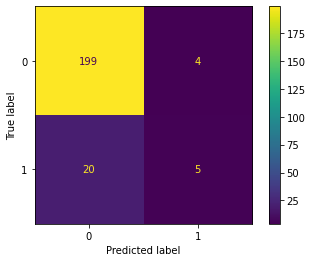

In [2]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

from util import fit_predict_evaluate

model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

The accuracy is high (because of the data imbalance) and the names it is learning are probably overfitting tot then names currently in the news (e.g. only the current U.S. president will get recognized and not the next one).

In [3]:
from util import show_most_informative_features
show_most_informative_features(model)

1.5957          kevin    -0.6500            met
1.2503     temptation    -0.6428            dit
1.1765          blind    -0.6123         waarom
1.1191           zijn    -0.5798           over
1.1042      tegenslag    -0.5784           moet
1.0895           mike    -0.5149           deze
1.0765      clarckson    -0.5106            die
1.0765         jeremy    -0.4953             zo
1.0636          julie    -0.4746            mag
1.0380          loopt    -0.4623            ons


## Approach 2: SpaCy
Let’s see whether spacy can also recognize proper names.

In [4]:
import spacy
from pprint import pprint
nlp = spacy.load('nl_core_news_sm')
pprint([(x.text,x.pos_,x.dep_,[(x.text,x.dep_) for x in list(x.children)]) for x in nlp(u"Zanger Arno overleden")])

[('Zanger', 'NOUN', 'nsubj', [('Arno', 'appos')]),
 ('Arno', 'PROPN', 'appos', []),
 ('overleden', 'VERB', 'ROOT', [('Zanger', 'nsubj')])]


Seems to already give a label to proper pronouns. To now what each part-of-speech (pos) tag means, you can take a look at [this page](https://v2.spacy.io/api/annotation).
Let's now create a similar function as for adjectives, but now for pronouns:

In [5]:
def contains_pronoun(headline):
    return any(x.pos_ == 'PROPN' for x in nlp(headline))

print(contains_pronoun(u"Zanger Arno overleden"))
print(contains_pronoun(u"Belgische rockzanger overleden"))

True
False


f-score: 0.2543352601156069
Confusion matrix: (TP: 77, FP: 126, FN: 3, TN: 22)
Accuracy=43.42% (99/228)


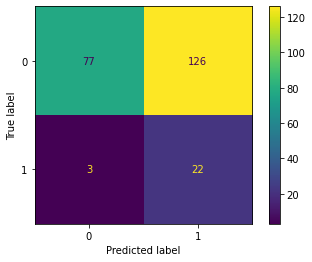

In [7]:
from util import print_evaluation
prediction = test_x.apply(contains_pronoun)
print_evaluation(test_y, prediction)

There are a lot more false postivies than expected. Let's take a look:

In [8]:
# False positives
prediction = train_x.apply(contains_pronoun)
train_x[(prediction != train_y) & (prediction == 1)][:5]

Test      
583   1459    "Gert en James hebben een relatie": nieuwe gas...
102   270     Hij is de beroemdste peuter van België, maar w...
200   513     13.000 euro per maand? Voor Verhofstadt is zij...
500   1249    Dit is het enige hotel in Vlaanderen met meer ...
307   774     Doorbraak in onderzoek naar plofkraken: schepe...
Name: Headline, dtype: object

Some seem wrongly labeled in the dataset (e.g. "Gert" and "Verhofstadt" are clearly proper nouns). Words like "Manneke Pis" or "Vlaanderen" are also proper nouns, but not seen as this in this dataset.

In [9]:
false_positive = "Hij is de beroemdste peuter van België, maar wie woont er naast? Op bezoek bij de buren van Manneke Pis"
pprint(list([(x.text, x.pos_, x.tag_) for x in nlp(false_positive)]))

[('Hij', 'PRON', 'VNW|pers|pron|nomin|vol|3|ev|masc'),
 ('is', 'AUX', 'WW|pv|tgw|ev'),
 ('de', 'DET', 'LID|bep|stan|rest'),
 ('beroemdste', 'ADJ', 'ADJ|prenom|sup|met-e|stan'),
 ('peuter', 'NOUN', 'N|soort|ev|basis|zijd|stan'),
 ('van', 'ADP', 'VZ|init'),
 ('België', 'PROPN', 'N|eigen|ev|basis|onz|stan'),
 (',', 'PUNCT', 'LET'),
 ('maar', 'CCONJ', 'VG|neven'),
 ('wie', 'PRON', 'VNW|vb|pron|stan|vol|3p|getal'),
 ('woont', 'VERB', 'WW|pv|tgw|met-t'),
 ('er', 'ADV', 'VNW|aanw|adv-pron|stan|red|3|getal'),
 ('naast', 'ADP', 'VZ|fin'),
 ('?', 'PUNCT', 'LET'),
 ('Op', 'ADP', 'VZ|init'),
 ('bezoek', 'NOUN', 'N|soort|ev|basis|onz|stan'),
 ('bij', 'ADP', 'VZ|init'),
 ('de', 'DET', 'LID|bep|stan|rest'),
 ('buren', 'NOUN', 'N|soort|mv|basis'),
 ('van', 'ADP', 'VZ|init'),
 ('Manneke', 'PROPN', 'SPEC|deeleigen'),
 ('Pis', 'PROPN', 'SPEC|deeleigen')]
